<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/NeuralNets/NN_Numerical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are going to take text-based features and apply a simple, fully-connected neural network to them. Atually, let's use images - that's what the tutorial does. Let's only consider Meander for the time being.

In [77]:
# General
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import PIL
from PIL import Image
import pandas as pd
import os
import math

# Image Reading
import cv2
import glob

# Other ML Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Torch General
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn # loss functions, neural network type (convolutional, linear, etc.)
import torch.optim as optim # optimization functions (sgd)
import torch.nn.functional as F # functions without parameters - activation functions (Relu, etc.) (also included in nn package, could use, but functional package is "better")
from torch.utils.data import DataLoader
import torchvision.datasets as datasets # torch has a LOT LOT LOT of standard datasets (ImageNet, MNIST, etc.)
import torchvision.transforms as transforms # transformations for dataset
from torch.utils.data.sampler import SubsetRandomSampler # PyTorch train test split

First to load the data.

## Load Data

### Preprocessing

In [78]:
# Fix Duplicates
# Our duplicates are 5, 23, 31 patient_ids
def fix_duplicate_ids(df, patient_ids, exam_ids, new_ids):

  df = df.copy()
  
  for i in range(len(patient_ids)): # don't need the actually patient_id numbers, but important that user knows what they are
    df["ID_PATIENT"][df["_ID_EXAM"] == exam_ids[i]] = new_ids[i]

  return df

In [79]:
def feature_normalization(df):

  avg_dev = df.mad(axis = 0)
  std_dev = df.std(axis = 0)

  df = df.sub(avg_dev)
  df = df.divide(std_dev)

  return df

In [80]:
class PDDataset(Dataset):
  def __init__(self):
    # Data loading
    spiral_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/NewSpiral.csv')
    meander_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/NewMeander.csv')

    data_all = pd.concat((spiral_df, meander_df))
    data_all = fix_duplicate_ids(data_all, [5, 23, 31], ['P25', 'P3', 'P26'], [500, 501, 502])

    # Normalization
    X = data_all[['RMS', 'MAX_BETWEEN_ET_HT', 'MIN_BETWEEN_ET_HT', 'STD_DEVIATION_ET_HT', 'MRT', 'MAX_HT', 'MIN_HT','STD_HT', 'CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT']]
    X = feature_normalization(X)
    
    # We must avoid shuffling the data now. It should stay in order all throughout the process
    X = X.to_numpy(dtype=float)
    y = data_all['CLASS_TYPE'].to_numpy()
    
    y = y - 1 # so we have labels 0 and 1, not 1 and 2

    self.n_samples = data_all.shape[0]

    self.x = torch.from_numpy(X).float() # creates tensor from numpy array, making it float as expected by model
    self.y = torch.from_numpy(y).long() # y_all is numpy array too, making it a long as expected by model
  
  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x[index], self.y[index]

  # to return size
  def __len__(self):
    return self.n_samples

In [81]:
dataset = PDDataset() # Meander Dataset object

# Why the warning?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
first_row = dataset[0]
feature0, label0 = first_row
print(feature0, label0)

tensor([ 7.1436,  7.8385,  3.2998, -0.1434,  4.7975,  8.7665, -0.2707,  4.8289,
         0.8604]) tensor(0)


In [83]:
len(dataset) # make sense, 264 * 2

528

### DataLoader


In [89]:
# Dataloader to load whole dataset
# Shuffle: no shuffle should happen! We don't want to mix up the data, since patient info must correspond with the proper labels for diagnosis
# num_workers: faster loading with multiple subprocesses simultaneously, set to 0 if error occurs when loading

In [90]:
# To perform train test split, we'll use sklearn... https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _ , _ = train_test_split(
    range(len(dataset)),
    dataset.y,
    stratify=dataset.y,
    test_size=test_size,
    random_state=seed
)

In [91]:
# train_indices is indices of the training values while test_indices is indicies of the testing values. Let's split our data like such.

# can I concatenate to a dataset object??? we wont worry about it right now. This is for patient level diagnosis...

# generate subset based on indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [92]:
train_dataset

In [93]:
len(train_dataset), len(test_dataset)

(396, 132)

In [94]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers =2)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True, num_workers =2)

## Defining the Network

ACTIVATION FUNCTION DECIDES WHAT IS SENT TO THE NEXT LAYER - IT IS between LAYERS.

Now to create the fully connected network.

In [84]:
class NN(nn.Module):
  def __init__(self, input_size, output_size): # input-size = 9, num_classes = 2 (PD/no PD), which is the output size for each row

    super(NN, self).__init__() # initializes the NN class that we're defining
    self.fc1 = nn.Linear(input_size, 64) # 5000 nodes - WAYY too much
    self.dt1 = nn.Dropout(0.1, inplace=False)
    self.fc2 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(16, output_size)
    #self.hd1 = nn.Linear(32, hidden_size1)
    
    #self.hd2 = nn.Linear(hidden_size1, hidden_size2)
    

  def forward(self, x): # run on some input x, which is the images which we run through fc1 and fc2 layers created above (and add the reLU activation function it between)
    x = F.relu(self.fc1(x))
    # x = F.relu(self.hd1(x))
    x = self.dt1(x)
    x = torch.sigmoid(self.fc2(x)) # functional library.sigmoid is deprecated
    # x = F.relu(self.hd2(x))
    x = self.fc3(x)
    return x

### Quick Test

What the model should output it something of shape [264 (140 + 124), 2]. For each image, it should predict the probability of it being in class 1 or 2 and return both of those.

## Set Device + Init Hyperparams

In [85]:
# Device set 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # google colab provides cuda gpu
print (device)

cuda


In [87]:
# Hyperparams
input_size = 9 # size of 1 row of data
num_classes = 2 # which is output_size

# tunables
test_size = 0.25
learning_rate = 0.1
batch_size = 256
num_epochs = 500
seed = 0 # just random state to start at

In [88]:
# input-size really refers to the size of 1 row of data.
# batch-size is the number of rows being fed to the model at one time

model = NN(9, 2) 
print (model)

# 264 spiral, 264 meander images
# 35 non PD patients, 31 PD patients, each who drew 4 spirals and 4 meanders
x = torch.randn(64, 9) # 64 batch size, 9 x 1 is the size of 1 row of data. This is the shape of what will be fed to the model at one time. (2D array of 64 x 9)
print (model(x).shape)

NN(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (dt1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)
torch.Size([64, 2])


## Initialize Network

In [95]:
model = NN(input_size = input_size, output_size = num_classes).to(device) # input-size??

In [96]:
# Loss + Optimizer
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # optimizer function

## Train Network

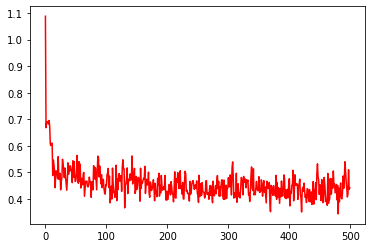

In [97]:
# epochs: number of times network sees images. 1 epoch - seen all images once
loss_values = [] * 1

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader): # parts of the train_loader, (data,targets) in tuple together, batch_idx there before
        
        # Get data to cuda (that's our device, if it's possible)
        data = data.to(device=device)

        targets = targets.to(device=device)

        # print (data.shape)

        # Get to correct shape, which is a 2D matrix of 64 x 9, because model(x) of shape should be 64 x 2?
        # Data is already in this correct shape, examine why?
        # data = data.reshape(64, 9])

        # by looking at this, we see we have 7 batches: 6 of size 64, 1 of size 38.

        # forward propagation
        scores = model(data)
        loss = criterion(scores, targets)

        # backward propagation
        optimizer.zero_grad() # set all gradients to 0 for each batch so it doesnt store calculation from previous batch
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    loss_values.append(loss) # loss after each epoch

plt.plot(np.array(loss_values), 'r')

## Check Accuracy

In [98]:
def check_accuracy(loader, model):
  """ if loader.dataset.train: # if this is true, then it is loading and checking training data
    print ('Checking accuracy on training data')
  else: 
    print ('Checking accuracy on testing data')

  Appears to be error with this code  
  """

  # initializing
  num_correct = 0
  num_samples = 0
  y_pred = [] * 1
  y_true = [] * 1

  model.eval() # why this specifically?

  with torch.no_grad(): # so we don't have to compute gradients for accuracy
    for x, y in loader:
      x = x.to(device=device)
      y = y.to(device=device)

      y_true.append(y)
      
      # reshape useless here
      # x = x.reshape(x.shape[0], -1)

      scores = model(x)

      # print (scores) # this returns 6 arrays of 64 x 2 and 1 of 38 x 2

      # _, is don't store this part in anything
      _, prediction = scores.max(1) # gives us index of maximum score value (max along second dimension, reason for the 1) in predictions variable each time
      
      y_pred.append(prediction)
      
      num_correct += (prediction == y).sum()
      num_samples += prediction.size(0)

  model.train()
  acc = num_correct/num_samples
  return acc, y_true, y_pred

In [99]:
# running check_accuracy on training and test set
train_acc, y_train, train_pred = check_accuracy(train_loader, model)
test_acc, y_test, test_pred = check_accuracy(test_loader, model)

In [100]:
print(train_acc, test_acc)

tensor(0.7727, device='cuda:0') tensor(0.6515, device='cuda:0')


In [101]:
# The reason test_pred has two tensors is because it is 106 data, and 64 is batch size, so it happens in 1 batch of 64 and 1 batch of 42
test_pred

[tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
         0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
         1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
         0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')]

In [102]:
# consider if change batch size
if (device == torch.device('cuda')):
  test_pred = test_pred[0].to(device=cpu_device)
  y_test = y_test[0].to(device=cpu_device)


In [103]:
# 256 batch size means no need to concatenate

# test_pred = torch.cat(test_pred) # 
# y_test = torch.cat(y_test) # move tensor y_test to cpu for concatenation, gpu can't do that computationally

In [104]:
conf_mat = confusion_matrix(y_test, test_pred)

In [105]:
tn, fp, fn, tp = conf_mat.ravel()

In [106]:
tp, fn, tn, fp

(45, 17, 41, 29)

True positive + false negative = number of PD patients

True negative + false positive = number of control patients